In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

# Localization - Line Map - CUDA kernel

In [20]:
#nbx
push!(LOAD_PATH, "src");
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils

In [21]:
Pose([0;0],0);
Measurement(1.0,π);

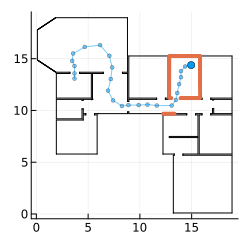

In [22]:
#nbx
using JLD2
using StatsBase: mean
using Geometry: bounding_box, Segment
using LinearAlgebra: norm

# fname = "data/data_2.jld2"
fname = "data/data_3.jld2"
d = load_object(fname)

_segs = env_segs = d[:env][:segs];

_xs  = d[:motion][:x];
_hds = d[:motion][:hd];
_ps   = [Pose(x,hd) for (x,hd) in zip(_xs, _hds)];

_dxs  = d[:motion][:dx]
_dhds = d[:motion][:dhd]
_us   = [(dx,dhd) for (dx,dhd) in zip(_dxs, _dhds)]

_a    = d[:sensor][:a];
_num_a = length(_a)
_zs   = d[:sensor][:z];
_ss   = [Measurement.(z,_a) for z in _zs]
_fov  = d[:sensor][:fov]
_zmax = d[:sensor][:zmax]

_T = length(_zs)

t = 1
# -----------------
plot(size=(250,250), aspect_ratio=:equal, legend=false)
plot!(_segs, c=:black)
plot!(_xs, marker=:o, label=nothing, markersize=2, c=col[1], alpha=0.5)
scatter!([_xs[t]], markersize=4, c=col[1])
scatter!(_ps[t], _ss[t], markersize=2, alpha=1, markerstrokewidth=0., marker=:o, c=col[2])

## Distributions we need

In [23]:
#nbx
push!(LOAD_PATH, "/home/ubuntu/workspace/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(5), ones(5))

5-element Vector{Float64}:
 0.12118465723806426
 0.7316858556903343
 0.9733178885841863
 0.10208333224500499
 0.06528815307511726

## Pose prior

In [24]:
#nbx
_bb = bounding_box(_segs);

# Caution, model depends on global variable.
# This isn't a "pure" function, in the 
# functional programming sense
@gen function pose_prior_model()
    x  ~ mvuniform([_bb[1]...],[_bb[2]...])
    hd ~ uniform(0,2π)
    return Pose(x,hd)
end;

In [25]:
pose_prior_model()

Pose([2.71609910482329, 0.5443367607113228], 0.48817871080083625)

## Motion model

In [26]:
#nbx
"""
    q = motion_model(p, u)

Sample a new pose `q` given the previous pose `p`, and 
some control data `u = (dx, dhd)`.
"""
@gen function motion_model(p, u, std)
    dx, dhd = u
    x   ~ diagnormal(p.x  + dx , [std, std])
    hd  ~ normal(p.hd + dhd, std)
    return p = Pose(x, hd)
end;

In [27]:
motion_model(_ps[1], _us[1], 0.1)

Pose([14.340076166757143, 14.349053887540533], -2.3067545484363645)

## Sensor model and map

The sensor model is the only part that depends on the map.
Since in this notebook we are only concerned with localization, not mapping,
we assume we are given a map `_m` of the environment, which we will now create.

In [28]:
include("src/cuda_raycaster.jl")

bench_cast! (generic function with 1 method)

In [29]:
sensor_mix_wrong = HeterogeneousMixture([diagnormal, mvuniform, mvuniform])

n = 5
args_wrong = ([0.4,0.3,0.3], zeros(n), ones(n), zeros(n), _zmax*ones(n), (_zmax-0.1)*ones(n), _zmax*ones(n))
z = sensor_mix_wrong(args_wrong...)
logpdf(sensor_mix_wrong, z, args_wrong...)

10.308952660647348

In [30]:
sensor_mix  = HeterogeneousMixture([normal, uniform, uniform])
sensor_dist = ProductDistribution(sensor_mix)
args = (fill([0.4,0.3,0.3], n), zeros(n), ones(n), zeros(n), _zmax*ones(n), (_zmax-0.1)*ones(n), _zmax*ones(n))
sensor_dist(args...)
logpdf(sensor_dist, z, args...)

5.517999150895674

In [31]:
function cast_GPU(p, segs_, a_)
    n = length(segs_)
    m = length(a_)

    z_ = CuArray(ones(m)*_zmax)
    p_ = CuArray([p.x;p.hd])


    blockdims = (32,8)
    griddims = cuda_grid((n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast!(segs_,a_,p_,z_)
    end
    return Array(z_)
end

cast_GPU (generic function with 1 method)

In [32]:
@gen function sensor_model(p, segs_, a_, std, dropout)

        z′ = cast_GPU(p, segs_, a_)
        m = length(a_)
        args = (
            fill([1.0-dropout-0.05, dropout, 0.05], m), # Mixture
            z′, std*ones(m),                            # diagnormal
            zeros(m), _zmax*ones(m),                    # mvuniform
            (_zmax-0.1)*ones(m), _zmax*ones(m)          # mvuniform
        );
        z ~ sensor_dist(args...)
        return z
end;

In [33]:
p = _ps[1]
segs_ = CuArray(stack(Geometry.vec.(_segs)))
a_ = CuArray(_a)
sensor_noise = 0.1
dropout = 0.1
sensor_model(p, segs_, a_, sensor_noise, dropout);

In [34]:
@btime sensor_model(p, segs_, a_, sensor_noise, dropout);

  356.022 μs (4747 allocations: 178.89 KiB)


```julia
352.035 μs (4760 allocations: 180.14 KiB)
```

In [35]:
ch = choicemap(:z => _zs[t])
@btime simulate(sensor_model, (p, segs_, a_, sensor_noise, dropout));
@btime generate(sensor_model, (p, segs_, a_, sensor_noise, dropout), ch);

  1.467 ms (20250 allocations: 690.58 KiB)
  1.191 ms (15570 allocations: 552.39 KiB)


```julia
1.307 ms (20306 allocations: 693.30 KiB)
1.028 ms (15613 allocations: 554.67 KiB)
```

In [36]:
S = 10
inds = 1:S:length(_a)
ch = choicemap(:z => _zs[t][inds])
@btime simulate(sensor_model, (p, segs_, a_[inds], sensor_noise, dropout));
@btime generate(sensor_model, (p, segs_, a_[inds], sensor_noise, dropout), ch);

  236.083 μs (2139 allocations: 76.36 KiB)
  203.654 μs (1671 allocations: 62.25 KiB)


```julia
224.300 μs (2195 allocations: 78.17 KiB)
190.063 μs (1714 allocations: 63.69 KiB)
```

In [37]:
S = 30
inds = 1:S:length(_a)
ch = choicemap(:z => _zs[t][inds])
@btime simulate(sensor_model, (p, segs_, a_[inds], sensor_noise, dropout));
@btime generate(sensor_model, (p, segs_, a_[inds], sensor_noise, dropout), ch);

  137.772 μs (795 allocations: 30.58 KiB)
  122.436 μs (639 allocations: 25.67 KiB)


```julia
137.832 μs (851 allocations: 32.38 KiB)
123.598 μs (682 allocations: 27.09 KiB)
```

## Static Model

In [38]:
#nbx
@gen function slam_kernel(t, state, segs_, a_, us, motion_noise, sensor_noise, dropout)
    
        p,_ = state
        u = us[t]
    
        p = {:pose}   ~ motion_model(p, u, motion_noise)
        z = {:sensor} ~ sensor_model(p, segs_, a_, sensor_noise, dropout) # GPU accelerated
        
    
    return (p, z)
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [39]:
#nbx
"""
    [(p,z),...] = static_slam_model(T, segs_, a_, us, motion_noise, sensor_noise, dropout, inds)

Static SLAM model ...
"""
@gen (static) function static_slam_model(T, segs_, a_, us, motion_noise, sensor_noise, dropout)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p = { :pose   } ~ pose_prior_model()
    z = { :sensor } ~ sensor_model(p, segs_, a_, sensor_noise, dropout)  # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p,nothing), segs_, a_, us, motion_noise, sensor_noise, dropout)
    
    return [(p,z);chain]
end

Gen.@load_generated_functions

In [40]:
#nbx
function create_obs_choices(t::Int, zs::AbstractVector, inds::StepRange{Int64, Int64})
    ch = choicemap()
    if t==1
        addr  = :sensor => :z 
    else
        addr  = :chain => t-1 => :sensor => :z 
    end
    ch[addr]= zs[t][inds]
    return ch
end

function create_obs_choices(ts::UnitRange{Int64}, zs::AbstractVector, inds::StepRange{Int64, Int64})
    ch = choicemap()
    for t=ts
        if t==1
            addr  = :sensor => :z 
        else
            addr  = :chain => t-1 => :sensor => :z 
        end
        ch[addr]= zs[t][inds]
    end
    return ch
end

create_obs_choices (generic function with 2 methods)

In [41]:
T = 0
S = 100

inds = 1:S:length(_a)
motion_noise = 0.01
sensor_noise = 0.1
dropout = 0.1

args = (T, segs_, a_[inds], _us, motion_noise, sensor_noise, dropout)
ch = create_obs_choices(1:T, _zs, inds)
tr,w = generate(static_slam_model, args, ch);

In [42]:
get_choices(tr)

│
├── :pose
│   │
│   ├── :hd : 5.195908252783396
│   │
│   └── :x : [2.2456239505639903, 9.372238174138536]
│
├── :sensor
│   │
│   └── :z : [9.929417238199203, 0.3211183039332423, 4.914775715488739, 2.190797418715033]
│
└── :chain


## Particle filter

**Static** slam model with **unfolded kernel** --
Uses simple naive raycaster sensor model on GPU.
```julia
N = 5000
S = 30
PF steps = 10

  0.781425 seconds (4.12 M allocations: 184.799 MiB)
  0.794337 seconds (4.12 M allocations: 185.028 MiB)
  0.800327 seconds (4.12 M allocations: 185.180 MiB)
  1.241742 seconds (4.20 M allocations: 187.734 MiB, 25.02% gc time)
  0.771645 seconds (4.12 M allocations: 185.409 MiB)
  0.797350 seconds (4.12 M allocations: 185.486 MiB)
  0.799555 seconds (4.12 M allocations: 185.638 MiB)
  0.796406 seconds (4.12 M allocations: 185.714 MiB)
  1.222860 seconds (4.21 M allocations: 188.398 MiB, 25.61% gc time)
```

In [43]:
include("src/gen_utils.jl")

argdiffs (generic function with 1 method)

In [56]:

N = 5_000
S = 30
inds = 1:S:length(_a) 

T = 8

inds = 1:S:length(_a)
motion_noise = 0.001
sensor_noise = 0.1
dropout = 0.001

args = (segs_, a_[inds], _us, motion_noise, sensor_noise, dropout)
diffs = argdiffs([1; fill(0, length(args))])

ch = create_obs_choices(1, _zs, inds)

state = initialize_particle_filter(static_slam_model, (0, args...), ch, N);

println("N = $(N)")
println("S = $(S)")
println("PF steps = $(T)")
println("")
for t=1:T-1
    ch = create_obs_choices(t+1,_zs, inds)
#     b = maybe_resample!(state, ess_threshold=N/2)
    b = maybe_resample!(state, ess_threshold=100)
    println(b)
    @time particle_filter_step!(state, (t,args...), diffs, ch) 
#     println(minimum(state.log_weights), "  ,  " ,maximum(state.log_weights))
#     println(minimum(get_score.(state.traces)), " ,  ", maximum(get_score.(state.traces)))
end

N = 5000
S = 30
PF steps = 8

true
  0.965620 seconds (3.93 M allocations: 178.557 MiB, 10.76% gc time)
true
  0.820794 seconds (3.91 M allocations: 178.085 MiB)
false
  0.956951 seconds (3.93 M allocations: 178.961 MiB, 11.23% gc time)
false
  0.984308 seconds (3.93 M allocations: 179.059 MiB, 12.86% gc time)
false
  1.027232 seconds (3.93 M allocations: 179.215 MiB, 15.49% gc time)
false
  1.047200 seconds (3.93 M allocations: 179.340 MiB, 16.11% gc time)
false
  0.823457 seconds (3.91 M allocations: 178.695 MiB)


(0,)
(0,)
(0,)
(0,)


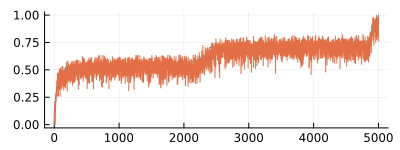

In [57]:
trs = state.traces
ws  = state.log_weights;
scores = get_score.(trs)

println(size(filter(isnan, ws)))
println(size(filter(isinf, ws)))
println(size(filter(isnan, scores)))
println(size(filter(isinf, scores)))



perm = sortperm(ws)
trs = trs[perm]
ws  = ws[perm]
scores = scores[perm]

ws     = peak_to_peak(ws)
scores = peak_to_peak(scores)

plot(size=(400,150), legend=nothing)
plot!(ws)
plot!(scores)

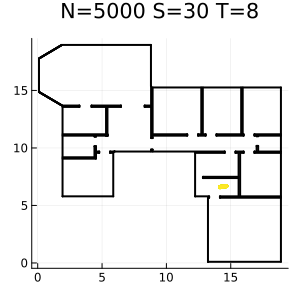

In [58]:
# ---------------------------
myplot = plot(size=(300,300), legend=nothing,  fmt = :png, title="N=$(N) S=$(S) T=$(T)")

num_scatter = 50
for (tr,w,sc) in zip(trs[end-num_scatter:end],ws[end-num_scatter:end],scores[end-num_scatter:end])
    r = tr[]
    p = r[1][1]
    plot!([p.x,p.x + 0.5*unit_vec(p.hd)], c=cgrad(:viridis)[w], linewidth=4)
end
plot!(_segs, c=:black, linewidth=2)
# savefig("_imgs/skip_measures_N$(N)_S$(S)_T$(T)_i$(i).png")
display(myplot)

In [54]:
function plot_static_tr(tr::StaticIRTrace)
    T, _, a_, = get_args(tr)
    
    a = Array(a_)
    rs = tr[]
    ps = [r[1] for r in rs]
    ss = [Measurement.(r[2],a) for r in rs]
    
    myplot = plot(aspect_ratio=:equal)
    plot!(_segs, label=nothing, c=:black)

    for t=1:T
        scatter!([ps[t].x], label=nothing, c=col[1])
        scatter!(ps[t],ss[t], markerstrokewidth=0.0, c=col[2], alpha=0.25, label=nothing)
    end
    return myplot
end

plot_static_tr (generic function with 1 method)

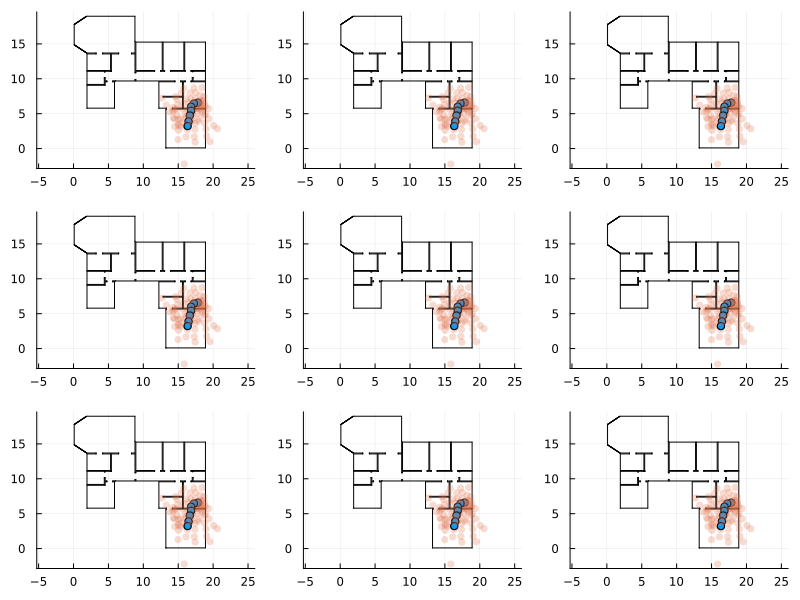

In [55]:
plot([plot_static_tr(tr) for tr in trs[end-9+1:end]]..., layout=(3, 3), size=(800,600))